In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt

import torch.optim as optim
torch.manual_seed(1) # set the random seed

import numpy as np

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
img_to_tensor = transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size (height, width)
    transforms.ToTensor()           # Convert the image to a tensor
])
trainingDataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/PlantDataset/training_database',transform=img_to_tensor)

validationDataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/PlantDataset/validation_database',transform=img_to_tensor)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 5, stride=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 5, stride=2, output_padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def trainAutoencoder(model, num_epochs=5, batch_size=32, learning_rate=1e-4):
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    train_loader = torch.utils.data.DataLoader(trainingDataset,
                                               batch_size=batch_size,
                                               shuffle=True)

    outputs = []
    for epoch in range(num_epochs):
        iteration = 0
        for img, label in train_loader:
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            print(iteration)

            out = recon[0].permute(1, 2, 0)
            out_np = (out.detach().numpy())

            plt.imshow(out_np)
            plt.show()
            plt.imshow(testImage)
            plt.show()
            iteration += 1

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [9]:
def get_acuracy(modelTrain,featuresAndLabels):

  modelTrain.eval()

  error_over = 0
  for feature, label in featuresAndLabels:
    if torch.argmax(modelTrain(feature),dim=1).item() != label:
      error_over+=1

  modelTrain.train()

  return error_over/len(featuresAndLabels)

In [10]:
def trainCNNClassifier(model,featuresAndLabelsTraining,featuresAndLabelsValidation, batch_size=64, num_epochs=5, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    train_loader = torch.utils.data.DataLoader(featuresAndLabelsTraining,
                                               batch_size=batch_size,
                                               shuffle=True)

    model.train()

    number, error = [], []

    for epoch in range(num_epochs):

        with torch.no_grad():
            actualError = get_acuracy(model, featuresAndLabelsValidation)
            error.append(actualError)
            print(actualError)
            number.append(epoch)
            i = 0
        for feature,label in iter(train_loader):
            i += 1
            if i % 5 == 0:
              print((i/(len(featuresAndLabelsTraining)/batch_size))*100, "%")
            output = model(feature)
            loss = criterion(output, label)
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()

    return number, error

In [11]:
class CNNClassifier2(nn.Module):
    def __init__(self):
        super(CNNClassifier2, self).__init__()
        self.fc1 = nn.Linear(512*3*3, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 3)
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1)
        self.conv4 = nn.Conv2d(64, 128, 3, stride=1,padding=2)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=1,padding=2)
        self.conv6 = nn.Conv2d(256, 512, 3, stride=1,padding=2)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = x.view(-1, 512*3*3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [12]:
myCNNClassifier2 = CNNClassifier2()

In [ ]:
number, error = trainCNNClassifier(myCNNClassifier2, trainingDataset, validationDataset, batch_size=64,  num_epochs=20, learning_rate=5e-5)

0.0761904761904762
7.279344858962693 %
14.558689717925386 %
21.83803457688808 %
29.117379435850772 %
36.39672429481347 %
43.67606915377616 %
50.955414012738856 %
58.234758871701544 %
65.51410373066425 %
72.79344858962693 %
80.07279344858964 %
87.35213830755232 %
94.63148316651501 %
0.0761904761904762
7.279344858962693 %
14.558689717925386 %
21.83803457688808 %
29.117379435850772 %
36.39672429481347 %
43.67606915377616 %
50.955414012738856 %
58.234758871701544 %
65.51410373066425 %
72.79344858962693 %
80.07279344858964 %
87.35213830755232 %
94.63148316651501 %
0.07539682539682539
7.279344858962693 %
14.558689717925386 %
21.83803457688808 %
29.117379435850772 %
36.39672429481347 %
43.67606915377616 %
50.955414012738856 %
58.234758871701544 %
65.51410373066425 %
72.79344858962693 %
80.07279344858964 %
87.35213830755232 %
94.63148316651501 %
0.07539682539682539
7.279344858962693 %
14.558689717925386 %
21.83803457688808 %
29.117379435850772 %
36.39672429481347 %
43.67606915377616 %
50.95541

In [ ]:
print(get_acuracy(myCNNClassifier2, validationDataset))

0.0761904761904762


In [ ]:
torch.save(myCNNClassifier2.state_dict(), "/content/CNNClassifier2.pth")

In [13]:
myCNNClassifier2.load_state_dict(torch.load("/content/CNNClassifier2.pth"))
myCNNClassifier2.eval()

CNNClassifier2(
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=3, bias=True)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

This is an image of class:  corn
The NN guesses that it is:  corn


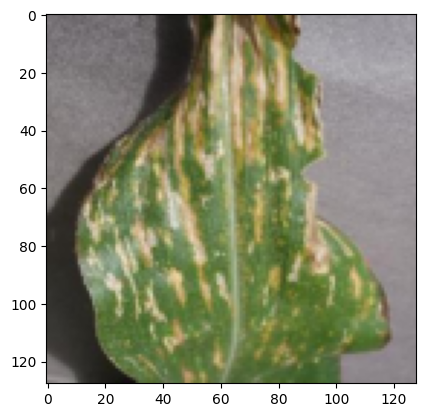

In [22]:
class_to_idx = validationDataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

test = validationDataset[252]

testImage = test[0]
print("This is an image of class: ", idx_to_class[test[1]])

print("The NN guesses that it is: ", idx_to_class[torch.argmax(myCNNClassifier2(testImage.unsqueeze(0)),dim = 1).item()] )



testImage = testImage.permute(1,2,0)

plt.imshow(testImage)